In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError
from typing import List, Tuple

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset
from models.VariableEncoder.training.configs import TrainingConfig
from models.VariableEncoder.training.configs import TrainingRunConfig


def get_normal_dataset(config: TrainingConfig) -> Tuple[CustomDataset, torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    vars = config.air_variable + config.surface_variable + config.only_input_variable + config.constant_variable

    weather = WeatherDataset(config.train_start, config.train_end, device=device, download_variables=vars, download_levels=config.levels)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    
    source, mean_std, var_vocab = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, level=config.levels)
    src_var_list = var_vocab.get_code(vars)
    tgt_var_list = var_vocab.get_code(config.air_variable + config.surface_variable)

    dataset = CustomDataset(source, config.src_time_len, config.tgt_time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    return dataset, mean_std, (src_var_list, tgt_var_list)


config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, mean_std, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                    (time: 87649, latitude: 36, longitude: 36,
                                level: 7)
Coordinates:
  * latitude                   (latitude) float64 20.04 20.74 ... 43.95 44.65
  * level                      (level) int64 50 100 200 300 500 700 1000
  * longitude                  (longitude) float64 115.3 116.0 ... 139.2 139.9
  * time                       (time) datetime64[ns] 2013-01-01 ... 2023-01-01
Data variables: (12/14)
    10m_u_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    10m_v_component_of_wind    (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    2m_temperature             (time, latitude, longitude) float32 dask.array<chunksize=(256, 36, 36), meta=np.ndarray>
    geopotential               (time, level, latitude, longitude) float32 dask.array<chunksize=(256, 7, 36, 36), meta=np.n

100%|██████████| 12/12 [00:20<00:00,  1.70s/it]


21.40970 sec


In [2]:
print(dataset.dataset_inc[1000])

([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011], [1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023])


In [3]:
%load_ext autoreload
%autoreload 2

from models.VariableEncoder.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/VariableEncoder/tb_logs/lightning_logs/nv1h4sp7/checkpoints/epoch=0-step=2920.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [4]:
from torch.utils.data import DataLoader
from tqdm import tqdm

train_ds, test_ds = torch.utils.data.random_split(
             dataset,
            [0.7, 0.3],
        )

model.setting()

data_loader = DataLoader(test_ds, batch_size=24, shuffle=True, drop_last=True)

loss_set = []
predict_set = []
label_set = []

for batch in tqdm(data_loader):
    # predict.size = (batch, time_len * var_len, hidden)
    # label.size = (batch, time_len, var_len, hidden)
    # loss.shape = (var_len, batch, time_len)
    loss, predict, label = model(batch)
    loss_set.append(loss)
    predict_set.append(predict)
    label_set.append(label)


loss_set = torch.cat(loss_set, dim=1)
predict_set = torch.cat(predict_set, dim=1)
label_set = torch.cat(label_set, dim=1)

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (576) must match the size of tensor b (672) at non-singleton dimension 1

In [6]:
loss_set = loss_set.mean(dim=1)
predict_set = predict_set.mean(dim=1)
label_set = label_set.mean(dim=1)

print(loss_set.shape)

torch.Size([84, 12])


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(loss: torch.Tensor, title, isAIR = False):
    if isAIR:
        loss = loss.swapaxes(0, 1)
    print(loss.shape)
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([12])


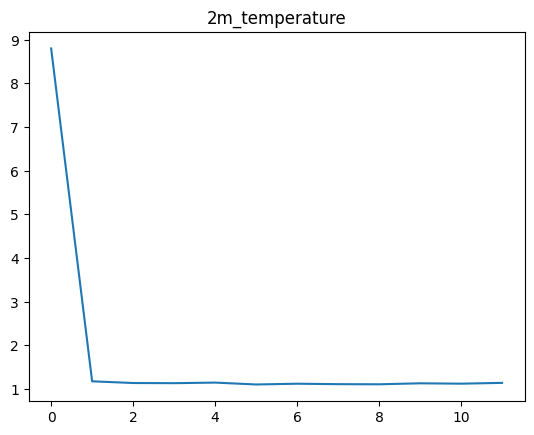

torch.Size([12])


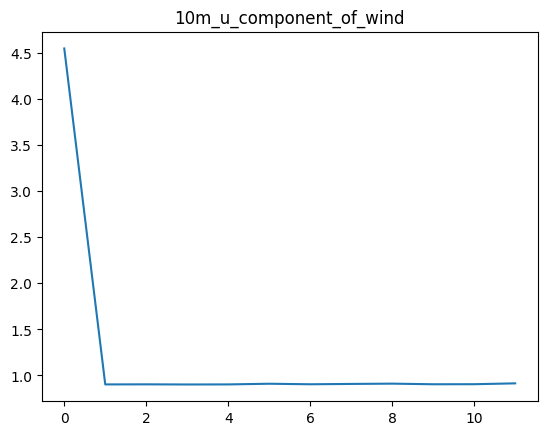

torch.Size([12])


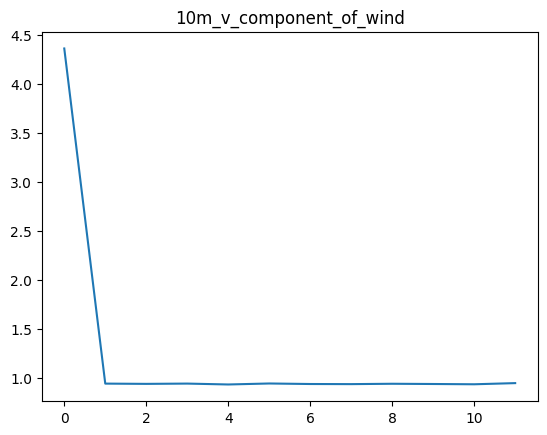

torch.Size([12])


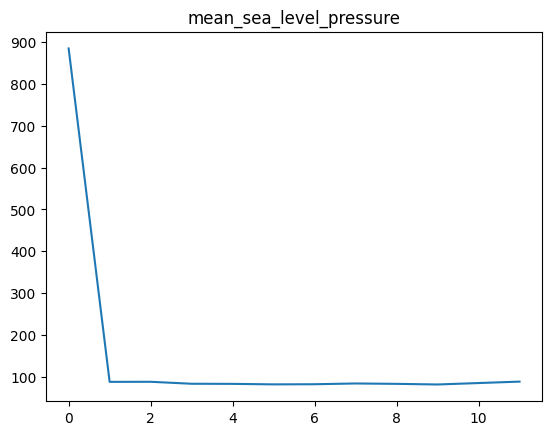

torch.Size([12])


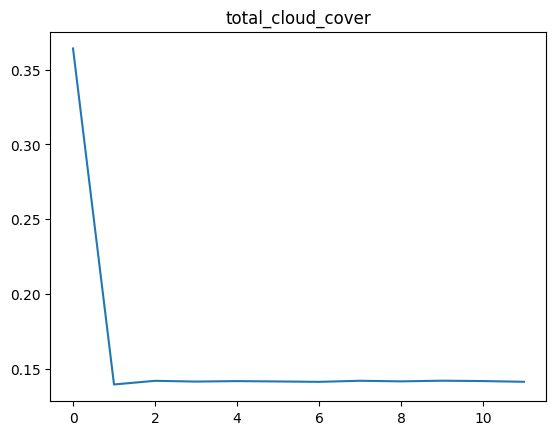

torch.Size([12])


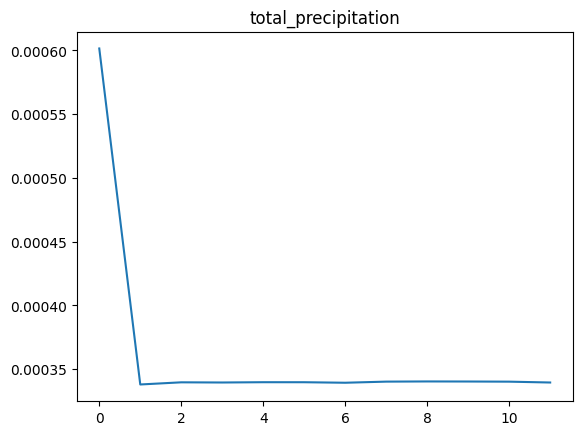

In [8]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize(torch.sqrt(loss_set[idx]), var, isAIR=False)

torch.Size([12, 13])


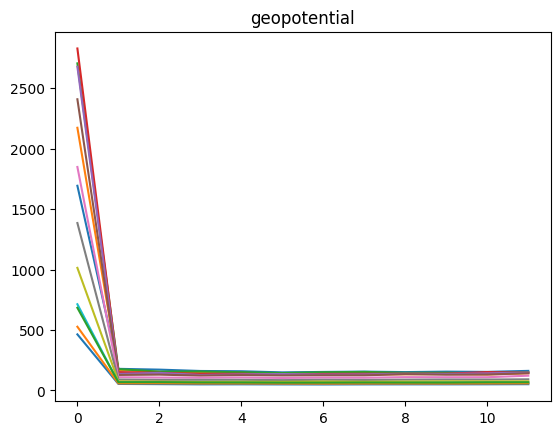

torch.Size([12, 13])


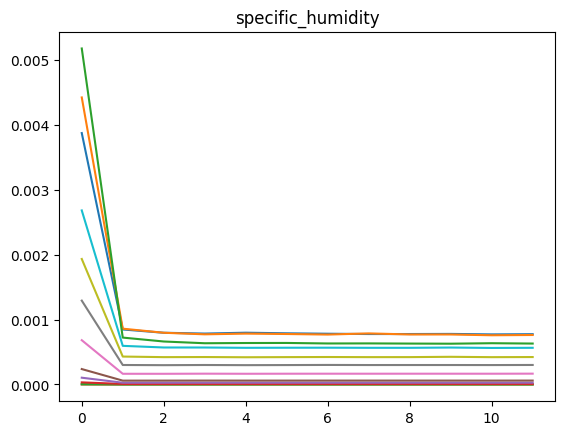

torch.Size([12, 13])


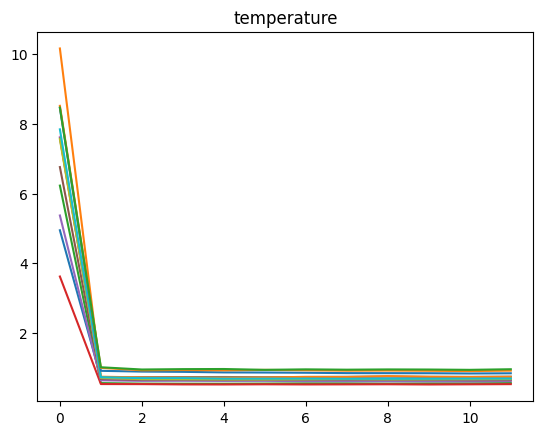

torch.Size([12, 13])


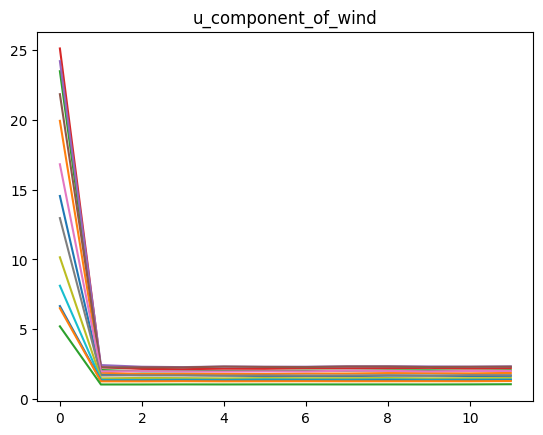

torch.Size([12, 13])


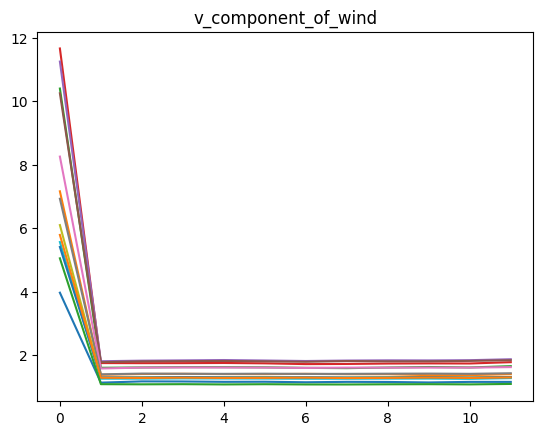

torch.Size([12, 13])


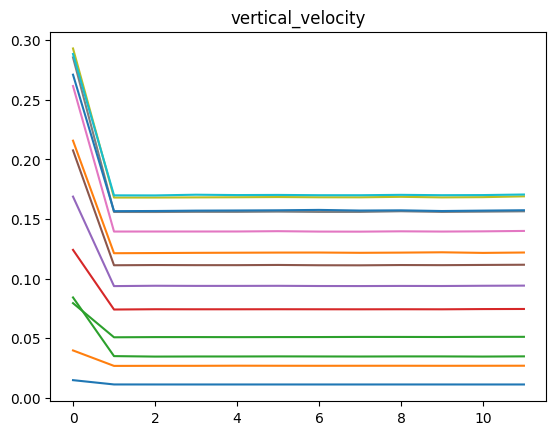

: 

In [9]:
for idx, var in enumerate(config.training.air_variable):
        air_list = [ ((idx)*len(config.training.levels)) + i for i in range(len(config.training.levels))]
        visualize(torch.sqrt(loss_set[air_list]), var, isAIR=True)

In [21]:
def visualize_real_predict(predict: torch.Tensor, label: torch.Tensor, title, isAIR = False):
    if isAIR:
        predict = predict.swapaxes(0, 1)
    if isAIR:
        label = label.swapaxes(0, 1)

    plt.plot(predict, label="predict")
    plt.plot(label, label="label")
    plt.title(title)
    plt.show()

In [16]:
def denormalize(inputs, mean_std) -> torch.Tensor:
    print(inputs.shape)
    mean = mean_std[:, 0].view(mean_std.size(0), 1)
    std = mean_std[:, 1].view(mean_std.size(0), 1)
    # 역정규화 수행
    denormalized = (inputs * std) + mean
    return denormalized

In [19]:
print(predict_set.shape)

torch.Size([84, 12])


In [20]:
predict_set = denormalize(predict_set, mean_std)
label_set = denormalize(label_set, mean_std)

torch.Size([84, 12])
torch.Size([84, 12])


In [ ]:
print(predict_set[0])

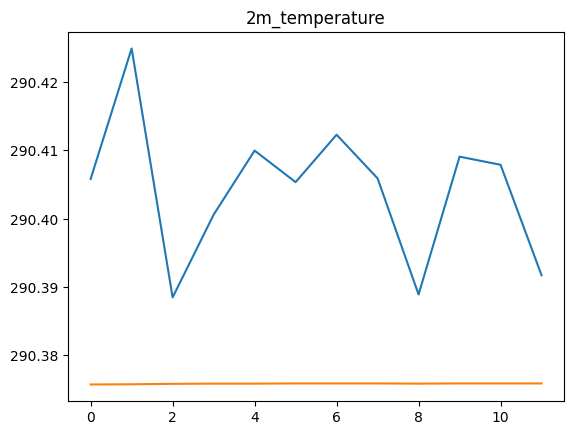

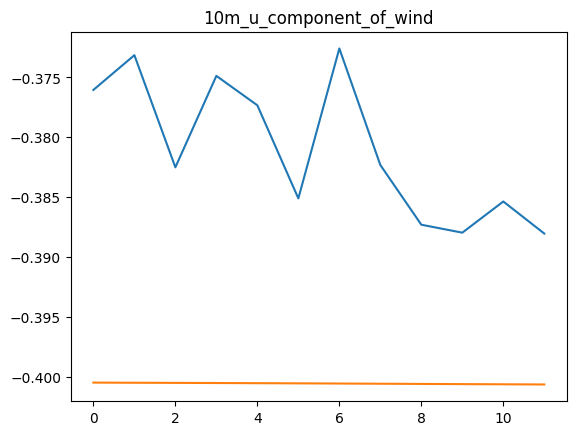

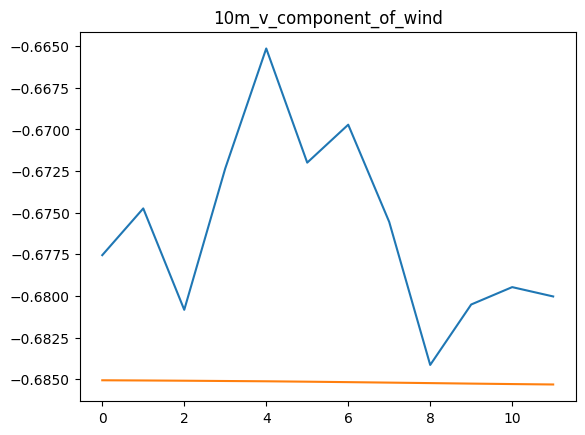

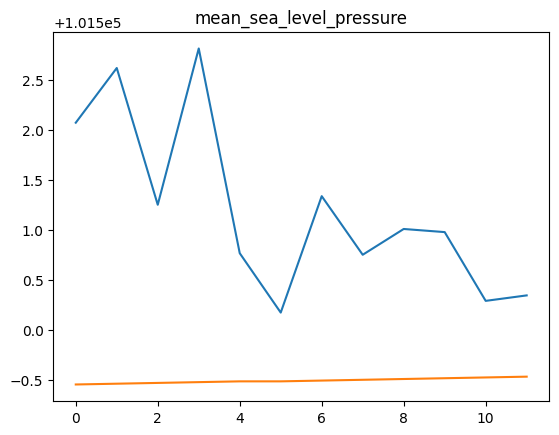

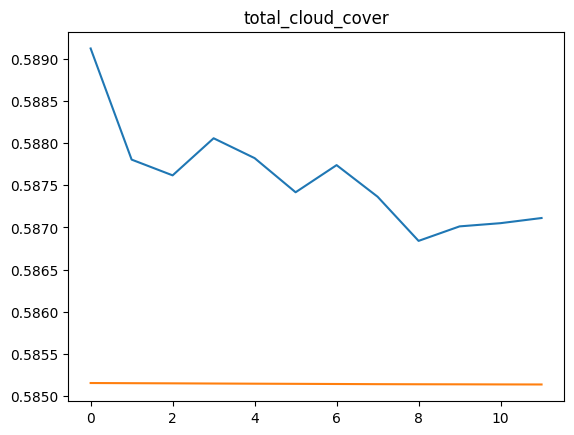

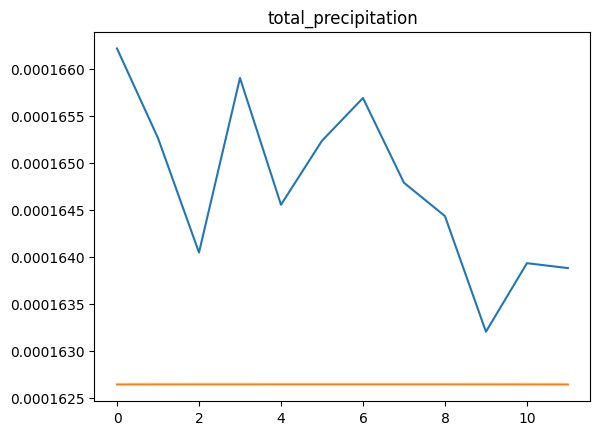

In [23]:
for i, var in enumerate(config.training.surface_variable):
        idx = len(config.training.air_variable) * len(config.training.levels) + i
        visualize_real_predict(predict_set[idx], label_set[idx], var, isAIR=False)